# This is a notebook about predicting aurora

# 0. Data Downloading

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scripts.plotting import *

In [2]:
import calendar
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, seasonal_plot, month_plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "figure.figsize": (7,5), "lines.linewidth": 2})

In [3]:
# Downloading Kp Index data from https://www.gfz-potsdam.de/
from getKpindex import getKpindex

kpindex_data = getKpindex(starttime="1932-01-01", endtime=datetime.today().strftime('%Y-%m-%d'), index="Kp")

# 1. Exploratory Data Analysis

## 1.1 Data Loading and Cleaning
Let's first take a look at the dataset. Clean it if necessary, and try to make sense of the data. 

In [4]:
# Since kpindex_data is a transposed 2D list or array, transpose it back to the correct format.
kpindex_data_transposed = list(zip(*kpindex_data))

# Convert to a DataFrame
kpindex_df = pd.DataFrame(kpindex_data_transposed, columns=["Datetime", "Kp_Index", "Status"])

# Convert 'Datetime' to pandas datetime object
kpindex_df['Datetime'] = pd.to_datetime(kpindex_df['Datetime'])

kpindex_df.head()

,Datetime,Kp_Index,Status
0,1932-01-01 00:00:00+00:00,3.333,def
1,1932-01-01 03:00:00+00:00,2.667,def
2,1932-01-01 06:00:00+00:00,2.333,def
3,1932-01-01 09:00:00+00:00,2.667,def
4,1932-01-01 12:00:00+00:00,3.333,def


In [5]:
# Check for any missing data
kpindex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270887 entries, 0 to 270886
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   Datetime  270887 non-null  datetime64[ns, UTC]
 1   Kp_Index  270887 non-null  float64            
 2   Status    270887 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 6.2+ MB


In [6]:
# Check for missing values
kpindex_df.isnull().sum()

Datetime    0
Kp_Index    0
Status      0
dtype: int64

In [7]:
kpindex_df.describe()

,Kp_Index
count,270887.000000
mean,2.169239
std,1.451499
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,9.000000


There is a lot of data, from 1932 to present, and it's even broken into every 3 hours periods. Let's consolidate the data a little bit by taking the daily max Kp index, as we intend to predict Kp index for the next few days, not next few hours. 

In [8]:
# Create a new column for the date only
kpindex_df['Date'] = kpindex_df['Datetime'].dt.date

# Group by the 'Date' column and calculate the daily max and std of Kp index
daily_max_df = kpindex_df.groupby('Date').agg(Daily_Kp_max=('Kp_Index', 'max')).reset_index()

daily_max_df = pd.DataFrame(daily_max_df)

daily_max_df = daily_max_df.rename(columns={"Date": "Datetime", "Daily_Kp_max": "Kp_Index"})

daily_max_df.head()

,Datetime,Kp_Index
0,1932-01-01,3.333
1,1932-01-02,5.000
2,1932-01-03,3.333
3,1932-01-04,2.000
4,1932-01-05,2.000


In [9]:
daily_max_df.describe()

,Kp_Index
count,33861.000000
mean,3.385272
std,1.492802
min,0.000000
25%,2.333000
50%,3.333000
75%,4.333000
max,9.000000


There is three columns in the downloaded data, corresponding to the datetime of the record, the Kp index at the time, and whether it's a recorded or predicted value. There is no missing data in the datasets, so I won't need to perform any imputation. 

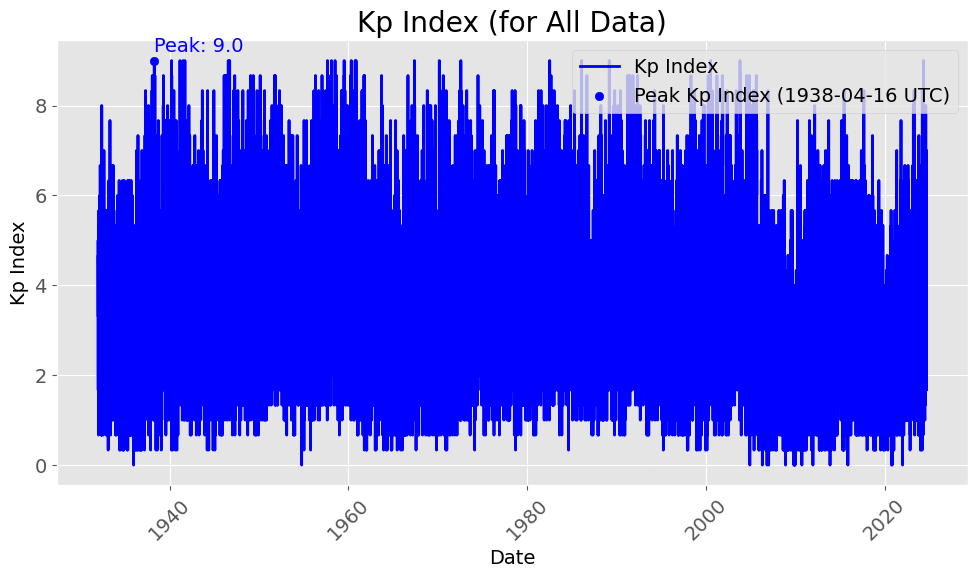

In [10]:
# To show all data:
plot_kp_index_by_date_range(daily_max_df)

This is a very large plot with many years of data. There doesn't seem to be an increase or decrease in max Kp index over the long timeframe, as suggested by an overall flat trend. 

Let's look at the annual max Kp index since 1932. 

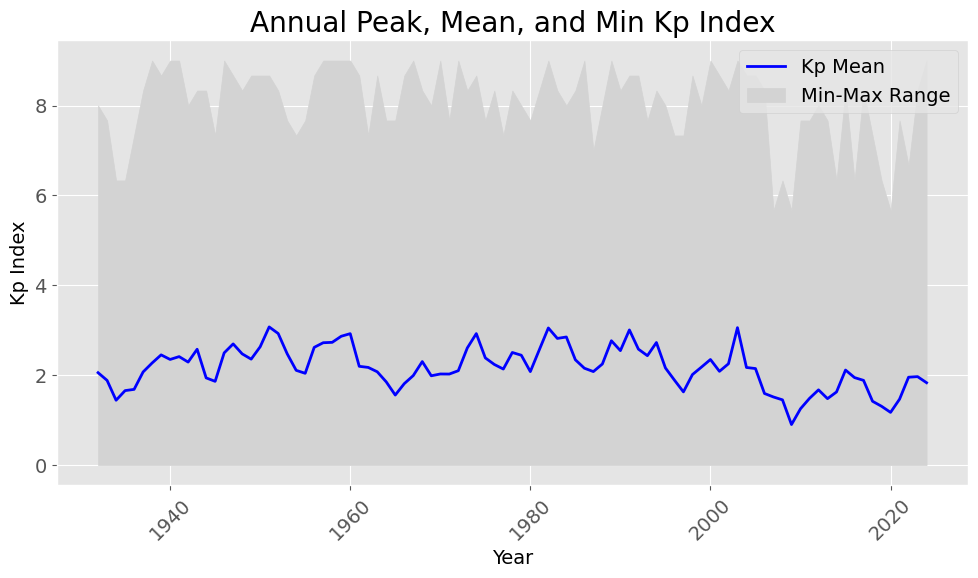

In [11]:
# Create a new column for the year
kpindex_df['Year'] = kpindex_df['Datetime'].dt.year

# Group by year and calculate max, min, and mean Kp index
annual_kp_df = kpindex_df.groupby('Year').agg(
    Kp_max=('Kp_Index', 'max'),
    Kp_min=('Kp_Index', 'min'),
    Kp_mean=('Kp_Index', 'mean')
).reset_index()

# Create a plot for the annual Kp Index (mean) with min-max range
plt.figure(figsize=(10, 6))

# Plot the mean Kp index
plt.plot(annual_kp_df['Year'], annual_kp_df['Kp_mean'], label="Kp Mean", color='blue')

# Fill between the min and max values to create a shaded area
plt.fill_between(annual_kp_df['Year'], annual_kp_df['Kp_min'], annual_kp_df['Kp_max'], color='lightgray', alpha=1, label="Min-Max Range")

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Kp Index')
plt.title("Annual Peak, Mean, and Min Kp Index")
plt.xticks(rotation=45)
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Between 1932 and 2024, the average annual Kp index doesn't seem to alter too much, but we can still observe a recent dip between 2009 and 2012, in both the max and mean Kp indices. 

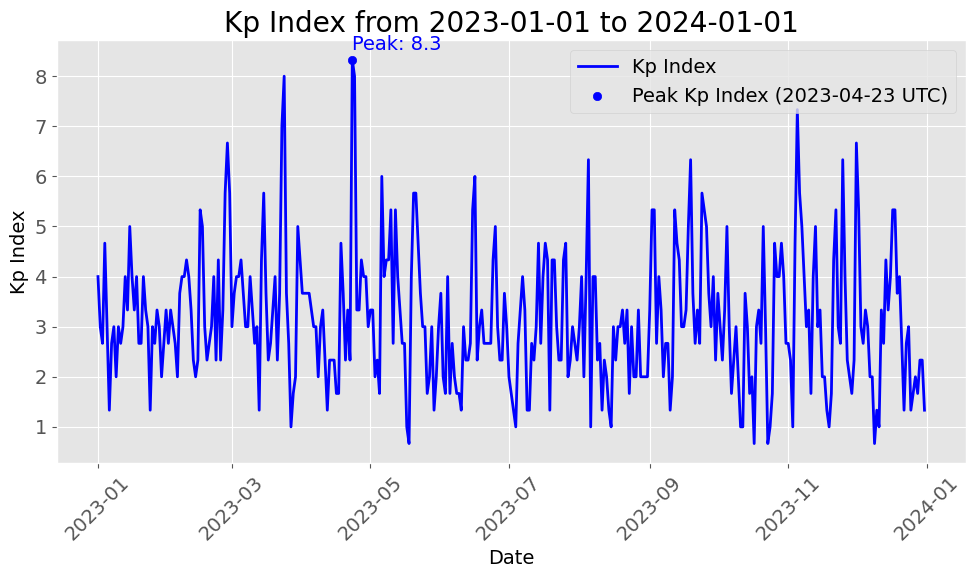

In [12]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_max_df, '2023-01-01', '2024-01-01')

There are ups and downs in the Kp Index but overall there isn't a upward or downward trend. 

Let's look at the past month only (August 2024). 

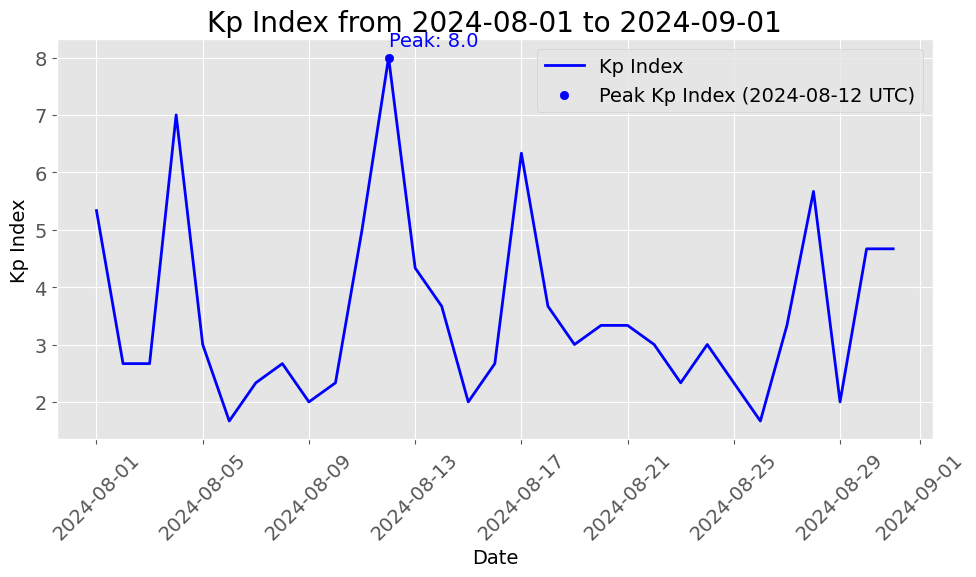

In [13]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_max_df, '2024-08-01', '2024-09-01')

Looks like there are variations of different widths. I personally was able to see aurora borealis on August 12th, 2024, which had the peak in Kp index. 

I saw another one in May 2024. Let's see if we can find it using the plot.

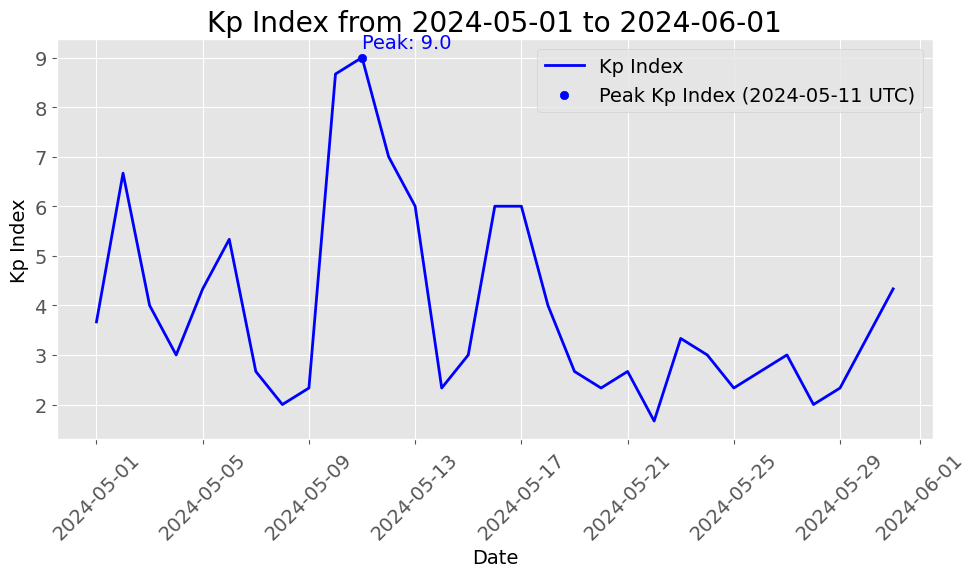

In [14]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_max_df, '2024-05-01', '2024-06-01')

What about in September 2024?

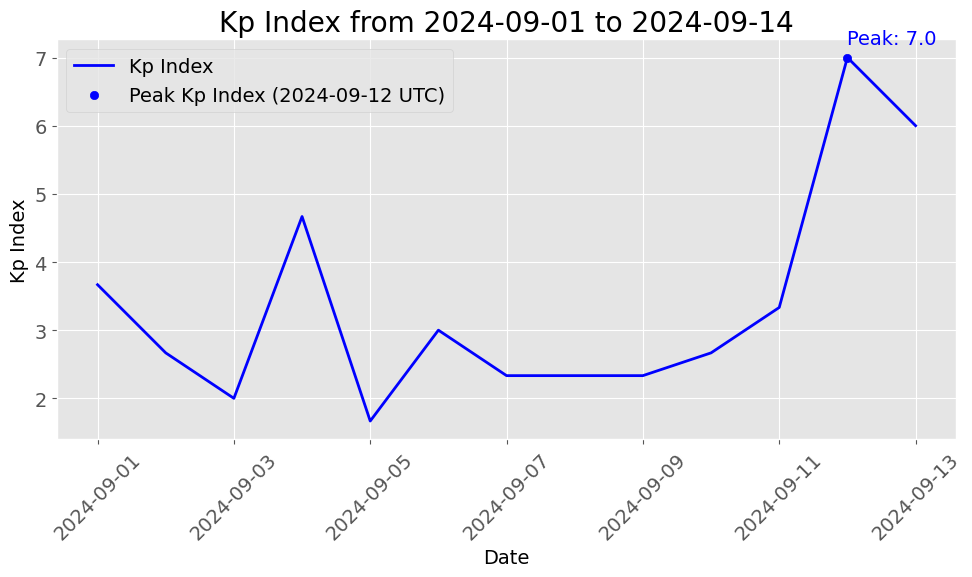

In [15]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_max_df, '2024-09-01', '2024-09-14')

## 1.2 Trends
With a lot of time-series data, there are temporal dependence, which maxs the value at a time is dependent on the value in the past. I will now take a look at this dependence, which is also called "autocorrelation". 

Firstly, let's examine if there are trends over the years. I'm going to try the polynomial with orders 0, 1, and 3 to try to capture the trend.

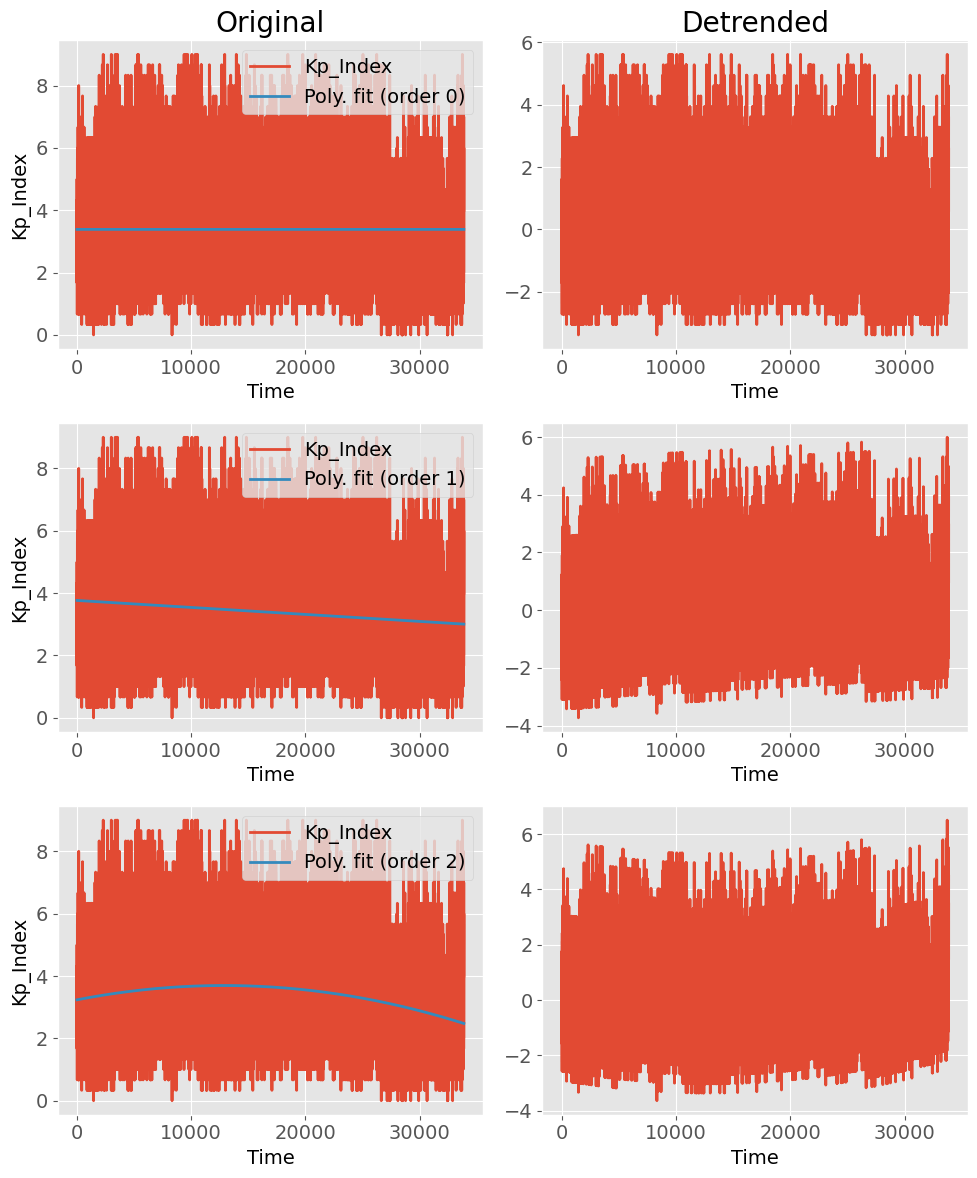

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for order in range(3):
    fit_label = f"Poly. fit (order {order})"
    daily_max_df[fit_label] = daily_max_df["Kp_Index"] - detrend(daily_max_df["Kp_Index"], order=order)
    daily_max_df[["Kp_Index", fit_label]].plot.line(xlabel="Time", ylabel="Kp_Index", ax=axes[order, 0])
    (daily_max_df["Kp_Index"] - daily_max_df[fit_label]).plot.line(xlabel="Time", legend=False, ax=axes[order, 1])
axes[0, 0].set_title("Original")
axes[0, 1].set_title("Detrended")
plt.tight_layout();

Looks like the polynomial fit of order 0 is already working pretty well. I guess the data over the entire period of time isn't increaseing or decreasing. The lines oscillates around Kp_Index of `3.385272`, as indicated in the `Poly. fit (order 0)`. We can use detrending to remove this. 

In [17]:
daily_max_df['detrended'] = daily_max_df["Kp_Index"] - daily_max_df['Poly. fit (order 0)']
daily_max_df.head()

,Datetime,Kp_Index,Poly. fit (order 0),Poly. fit (order 1),Poly. fit (order 2),detrended
0,1932-01-01,3.333,3.385272,3.764856,3.236765,-0.052272
1,1932-01-02,5.000,3.385272,3.764834,3.236836,1.614728
2,1932-01-03,3.333,3.385272,3.764811,3.236908,-0.052272
3,1932-01-04,2.000,3.385272,3.764789,3.236979,-1.385272
4,1932-01-05,2.000,3.385272,3.764766,3.237050,-1.385272


By subtracting all daily values with 3.385272, the lines should converge to 0, shown by the detrended polynomial 0 graph (top right). 

## 1.3 Seasonality

Let's do some exploration first. I'm curious to see how the peak Kp index repeat over days in a month, and months in a year and .

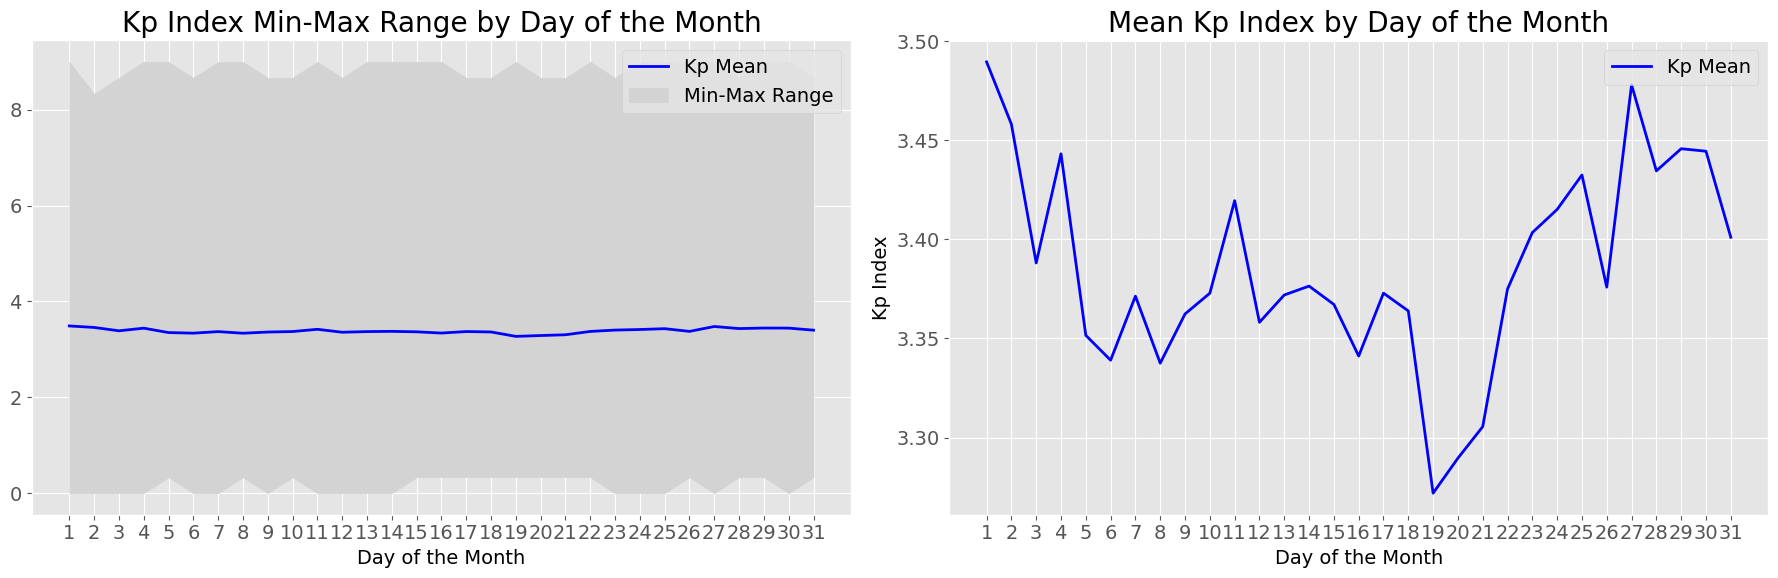

In [18]:
# Group by day of the month and calculate the mean, min, and max
day_of_month = daily_max_df.groupby(daily_max_df['Datetime'].dt.day).agg(
    Mean_dayofmonth_peak_Kp=('Kp_Index', 'mean'), 
    Min_dayofmonth_peak_Kp=('Kp_Index', 'min'), 
    Max_dayofmonth_peak_Kp=('Kp_Index', 'max')
).reset_index()

# Rename the 'Datetime' column to 'Day' since we are grouping by the day of the month
day_of_month.rename(columns={'Datetime': 'Day'}, inplace=True)

# Create subplots with two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot min, mean, max Kp index
axes[0].plot(day_of_month['Day'], day_of_month['Mean_dayofmonth_peak_Kp'], label="Kp Mean", color='blue')
axes[0].fill_between(day_of_month['Day'], day_of_month['Min_dayofmonth_peak_Kp'], day_of_month['Max_dayofmonth_peak_Kp'], color='lightgray', alpha=1, label="Min-Max Range")
axes[0].set_xlabel('Day of the Month')
axes[0].set_title("Kp Index Min-Max Range by Day of the Month")
axes[0].set_xticks(range(1, 32))
axes[0].legend()

# Plot mean Kp index
axes[1].plot(day_of_month['Day'], day_of_month['Mean_dayofmonth_peak_Kp'], label="Kp Mean", color='blue')
axes[1].set_xlabel('Day of the Month')
axes[1].set_ylabel('Kp Index')
axes[1].set_title("Mean Kp Index by Day of the Month")
axes[1].set_xticks(range(1, 32))
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


We can see the variation for day of a month is not too striking. Although the right graph showed ups and downs, keep in mind of the y axis. 

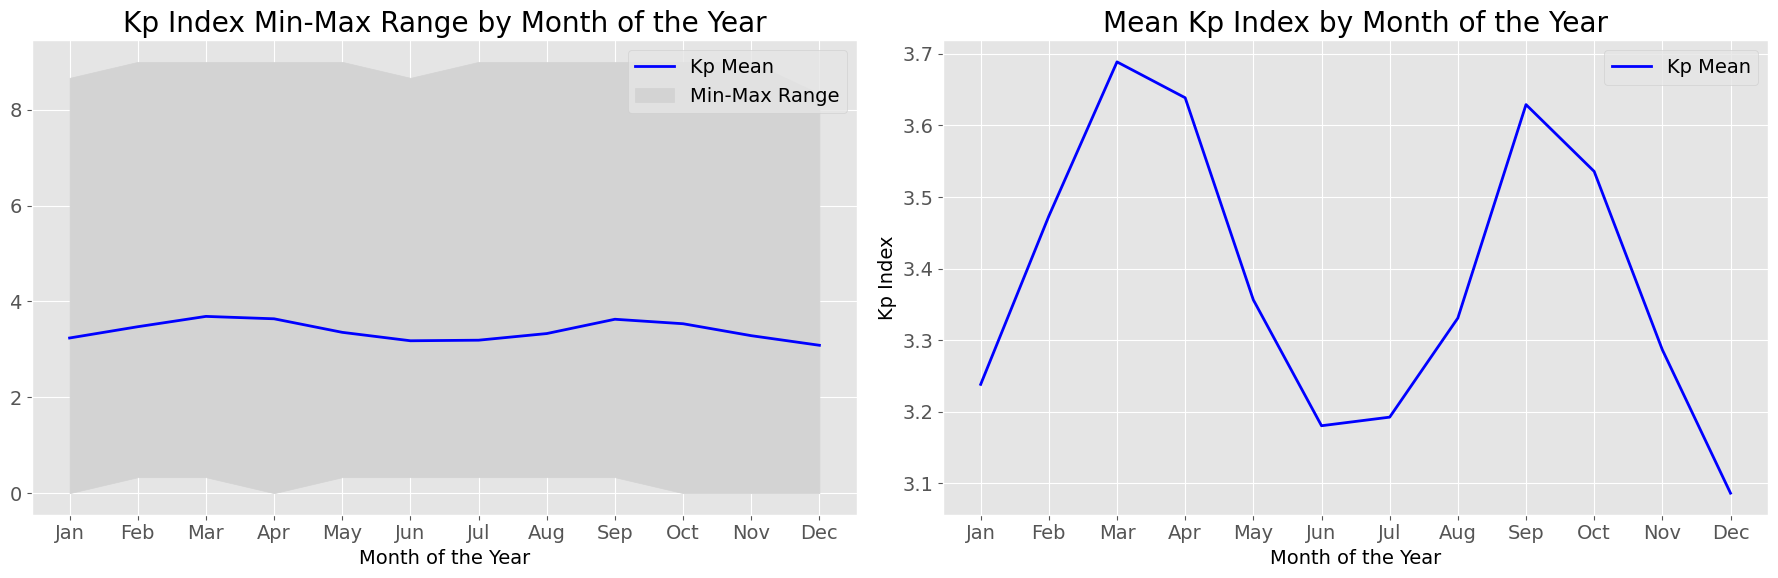

In [19]:
# Group by month of the year and calculate the mean, min, and max
month_of_year = daily_max_df.groupby(daily_max_df['Datetime'].dt.month).agg(
    Mean_monthly_peak_Kp=('Kp_Index', 'mean'), 
    Min_monthly_peak_Kp=('Kp_Index', 'min'), 
    Max_monthly_peak_Kp=('Kp_Index', 'max')
).reset_index()

# Rename the 'Datetime' column to 'Month' since we are grouping by the month of the year
month_of_year.rename(columns={'Datetime': 'Month'}, inplace=True)

# Create subplots with two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot min, mean, max Kp index
axes[0].plot(month_of_year['Month'], month_of_year['Mean_monthly_peak_Kp'], label="Kp Mean", color='blue')
axes[0].fill_between(month_of_year['Month'], month_of_year['Min_monthly_peak_Kp'], month_of_year['Max_monthly_peak_Kp'], color='lightgray', alpha=1, label="Min-Max Range")
axes[0].set_xlabel('Month of the Year')
axes[0].set_title("Kp Index Min-Max Range by Month of the Year")
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
axes[0].legend()

# Plot mean Kp index
axes[1].plot(month_of_year['Month'], month_of_year['Mean_monthly_peak_Kp'], label="Kp Mean", color='blue')
axes[1].set_xlabel('Month of the Year')
axes[1].set_ylabel('Kp Index')
axes[1].set_title("Mean Kp Index by Month of the Year")
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


We can see that for months in a year, the Kp index varies a bit more than days of a month. It tends to peak during March and September, and dips around between June to July and December to January. 

Let's save both month of a year and day of a month as addition features in our df. 

--- Work done til here ---

---

In [20]:
daily_max_df = daily_max_df.merge(month_of_year, left_on=daily_max_df['Datetime'].dt.month, right_on='Month', how='left')
daily_max_df

,Datetime,Kp_Index,Poly. fit (order 0),Poly. fit (order 1),Poly. fit (order 2),detrended,Month,Mean_monthly_peak_Kp,Min_monthly_peak_Kp,Max_monthly_peak_Kp
0,1932-01-01,3.333,3.385272,3.764856,3.236765,-0.052272,1,3.238071,0.000,8.667
1,1932-01-02,5.000,3.385272,3.764834,3.236836,1.614728,1,3.238071,0.000,8.667
2,1932-01-03,3.333,3.385272,3.764811,3.236908,-0.052272,1,3.238071,0.000,8.667
3,1932-01-04,2.000,3.385272,3.764789,3.236979,-1.385272,1,3.238071,0.000,8.667
4,1932-01-05,2.000,3.385272,3.764766,3.237050,-1.385272,1,3.238071,0.000,8.667
...,...,...,...,...,...,...,...,...,...,...
33856,2024-09-10,2.667,3.385272,3.005777,2.478061,-0.718272,9,3.629172,0.333,9.000
33857,2024-09-11,3.333,3.385272,3.005755,2.477945,-0.052272,9,3.629172,0.333,9.000
33858,2024-09-12,7.000,3.385272,3.005732,2.477829,3.614728,9,3.629172,0.333,9.000
33859,2024-09-13,6.000,3.385272,3.005710,2.477713,2.614728,9,3.629172,0.333,9.000


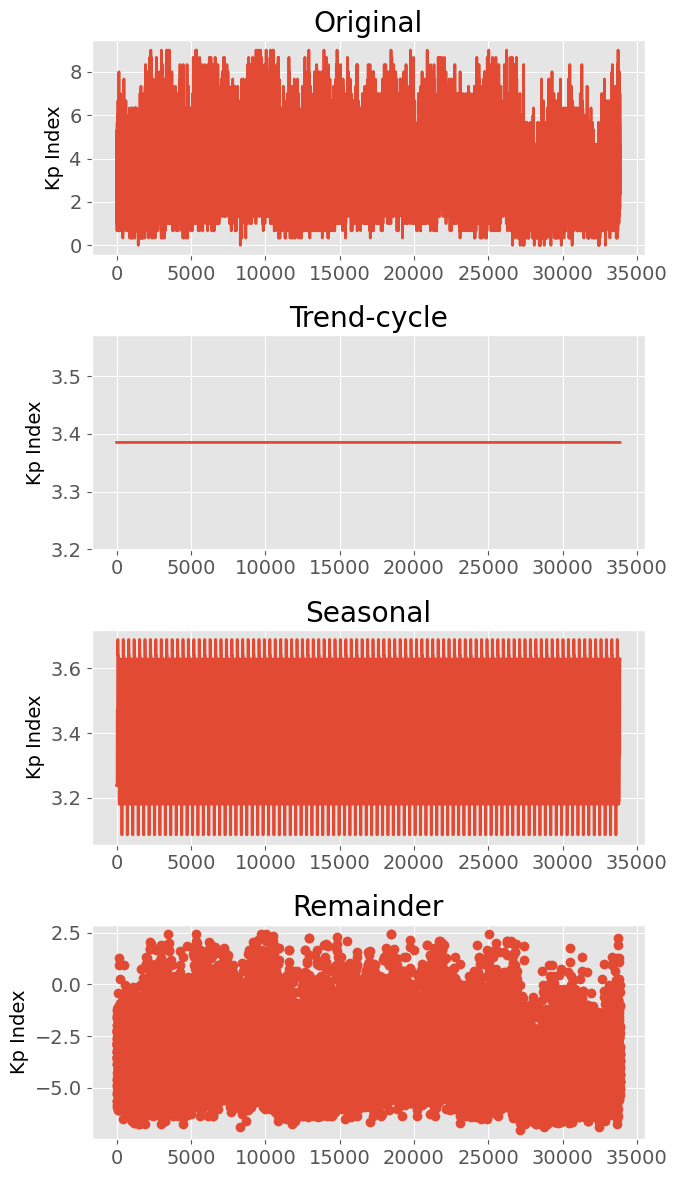

In [21]:
# Estimating the remainder
daily_max_df["remainder"] = daily_max_df["Kp_Index"] - daily_max_df["Poly. fit (order 0)"] - daily_max_df["Mean_monthly_peak_Kp"]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7, 12))
daily_max_df["Kp_Index"].plot.line(ylabel="Kp Index", title="Original", xlabel="", ax=axes[0])
daily_max_df["Poly. fit (order 0)"].plot.line(ylabel="Kp Index", title="Trend-cycle", xlabel="", ax=axes[1])
daily_max_df["Mean_monthly_peak_Kp"].plot.line(ylabel="Kp Index", title="Seasonal", xlabel="", ax=axes[2])
daily_max_df["remainder"].plot.line(ylabel="Kp Index", title="Remainder", ax=axes[3], marker="o", linestyle="")
plt.tight_layout();

Text(0, 0.5, 'ACF')

<Figure size 2000x600 with 0 Axes>

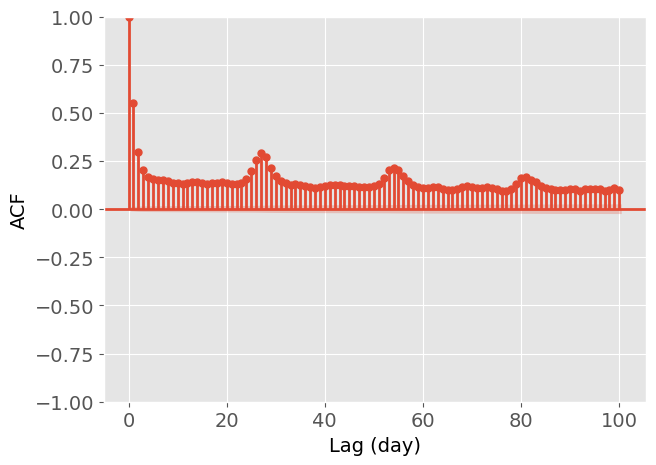

In [22]:
plt.figure(figsize=(20, 6))
plot_acf(daily_max_df["Kp_Index"], lags=100, title=None, bartlett_confint=True)
plt.xlabel("Lag (day)")
plt.ylabel('ACF')

Text(0, 0.5, 'PACF')

<Figure size 2000x600 with 0 Axes>

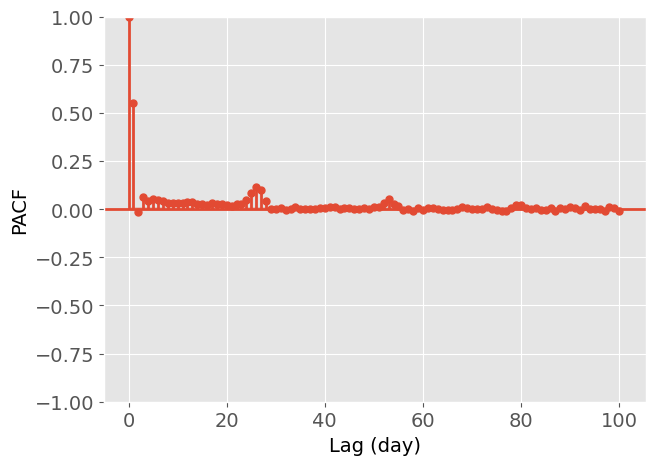

In [23]:
plt.figure(figsize=(20, 6))
plot_pacf(daily_max_df["Kp_Index"], lags=100, title=None)
plt.xlabel("Lag (day)")
plt.ylabel('PACF')

There seems to be a cycle of autocorrelation around every 25-30 lags. Maybe this is the cycle of the sun (the Sun rotates on its axis once in 27 days)? 

Also, as the ACF value drops rapidly after lag 3, there isn't really an obvious trend to observe, as we hypothesized earlier.

Let me first get the exact lag value. 

In [24]:
acf_data = acf(daily_max_df["Kp_Index"], nlags=100, bartlett_confint=True)
acf_data[:25]

array([1.        , 0.55384733, 0.29628413, 0.20318388, 0.16498839,
       0.15633515, 0.15288032, 0.15095012, 0.14407542, 0.13805935,
       0.13411087, 0.13290388, 0.137138  , 0.14357543, 0.14043949,
       0.13612242, 0.13187435, 0.13530988, 0.13828952, 0.13906061,
       0.13700503, 0.13030927, 0.13124604, 0.13685514, 0.15552208])

In [25]:
# Create lags array
lags = np.arange(len(acf_data))

# Define the range for finding the highest point
start_lag = 20
end_lag = 40

# Find indices within the specified lag range
indices_within_range = np.where((lags >= start_lag) & (lags <= end_lag))[0]

# Find the maximum ACF value within this range
max_index = indices_within_range[np.argmax(acf_data[indices_within_range])]
max_lag = lags[max_index]
max_acf_value = acf_data[max_index]

print(f'The maximum ACF value is at lag {max_lag} with a value of {max_acf_value}.')

The maximum ACF value is at lag 27 with a value of 0.29128377859751153.


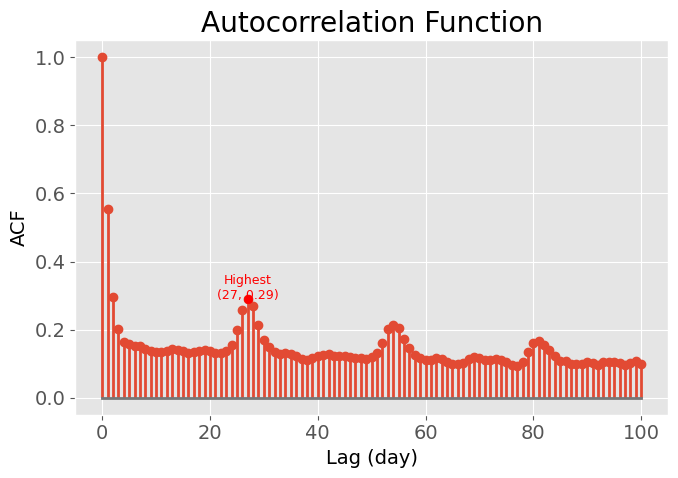

In [26]:
# Plot ACF
plt.stem(lags, acf_data, use_line_collection=True)
plt.xlabel("Lag (day)")
plt.ylabel('ACF')

# Annotate the highest point
plt.scatter(max_lag, max_acf_value, color='red', zorder=5)
plt.text(max_lag, max_acf_value, f'Highest\n({max_lag}, {max_acf_value:.2f})',
         color='red', fontsize=9, ha='center')

plt.title('Autocorrelation Function')
plt.tight_layout()
plt.show()

Let's explore how the Kp index repeats every 27 days.

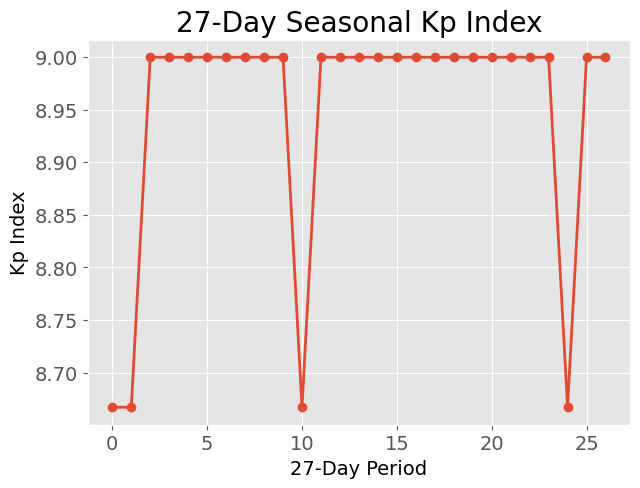

In [27]:
# Create a 27-day period identifier based on the day of the dataset
daily_max_df['27_Day_Group'] = daily_max_df.index % 27  # Grouping every 27 days

# Calculate the max for each 27-day group across all years
seasonal = daily_max_df.groupby('27_Day_Group')['Kp_Index'].max()

# Plot the seasonal pattern
ax = seasonal.plot.line(xlabel="27-Day Period", ylabel="Kp Index", 
                        title="27-Day Seasonal Kp Index", marker="o")


We can see that there are some variations of average Kp index in the 27 day period. However, keep in mind of the scale of changes, which is only from 3.34 to 3.48. The variation is not too big. 

There is also the solar cycle, which lasts for 11 years. Let's explore that

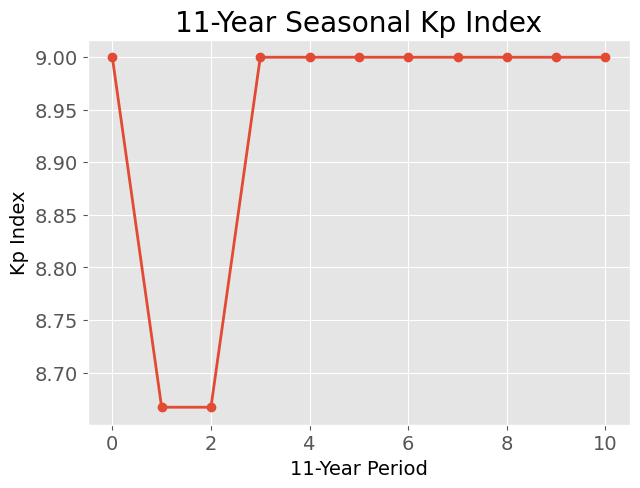

In [28]:
# Extract the year from 'Datetime'
daily_max_df['Year'] = daily_max_df['Datetime'].dt.year

# Create an 11-year period identifier based on the year. As the first conventionally stated solar cycle began in 1755. We subtract 1755 from each year to indicate which year is it at during a cycle. 
daily_max_df['11_Year_Group'] = (daily_max_df['Year'] - 1755) % 11

# Calculate the max for each 11-year group across all years
seasonal = daily_max_df.groupby('11_Year_Group')['Kp_Index'].max()

# Plot the seasonal pattern
ax = seasonal.plot.line(xlabel="11-Year Period", ylabel="Kp Index", 
                        title="11-Year Seasonal Kp Index", marker="o")

We can see that the average variation in Kp Index for 11 year period is larger, ranging from 3.0 to 3.7, as compared to the changes in the 27 day period above. 

So there seems to be the autocorrelation at 27 days. 

Let's use `STL` to remove this seasonality. This is a more advanced method of decomposition which uses LOESS (locally estimated scatterplot smoothing).

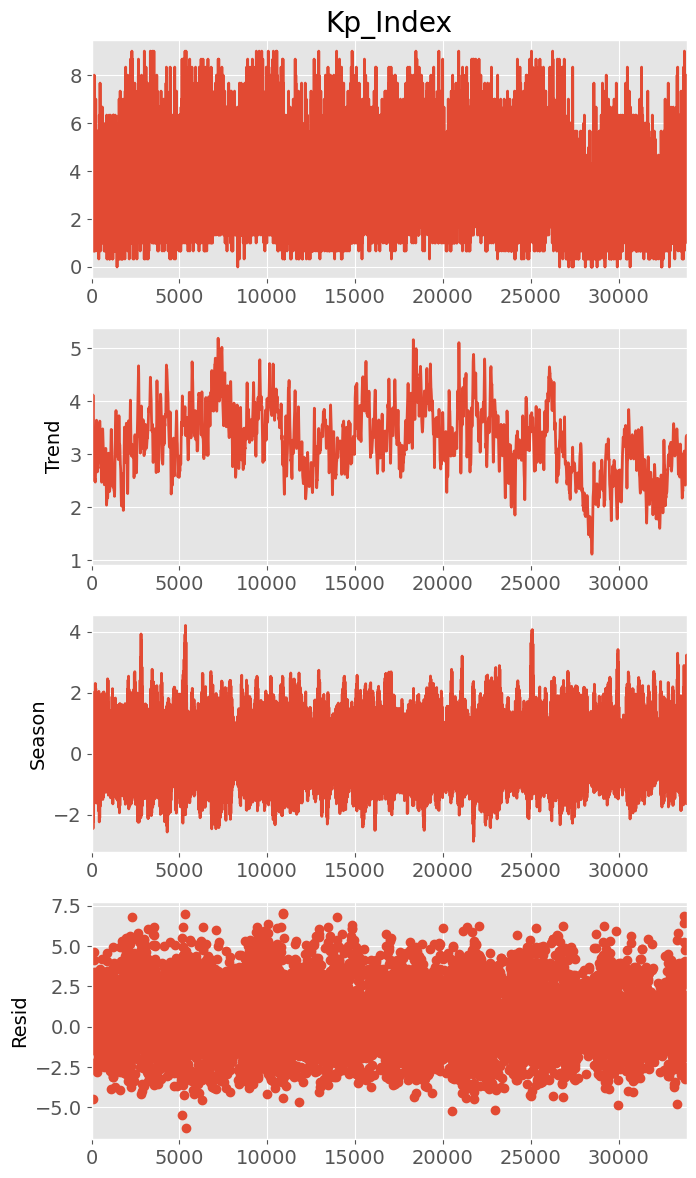

In [29]:
from statsmodels.tsa.seasonal import STL
model = STL(daily_max_df["Kp_Index"], period=27, trend=55, robust=True).fit()
with mpl.rc_context():
    mpl.rc("figure", figsize=(7, 12))
    model.plot()

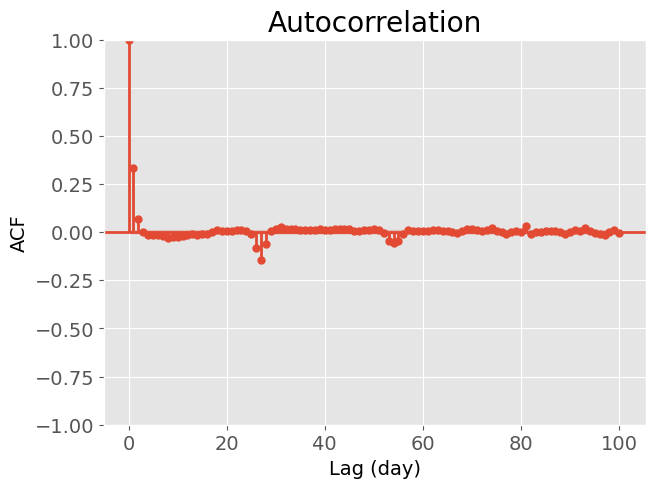

In [30]:
fig = plot_acf(model.resid, lags=100)
plt.ylabel("ACF")
plt.xlabel("Lag (day)");

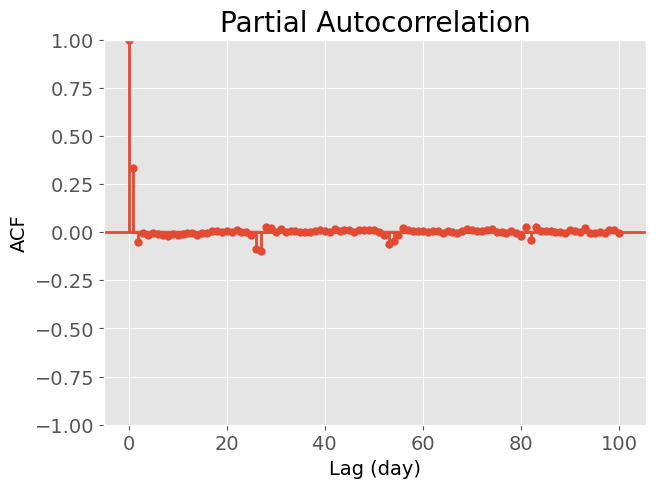

In [31]:
fig = plot_pacf(model.resid, lags=100)
plt.ylabel("ACF")
plt.xlabel("Lag (day)");

The detrended data looks much better. There seems to be still autocorrelation at the lag 1, which we can take care of in modelling. Also, although there are still some negatively correlated data points around lag 27, but it's pretty good already. 

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
wd_size = 20

daily_max_df['Kp_Index'].plot(ax=axes[0])
axes[0].set(ylabel='Kp_Index')
daily_max_df['Kp_Index'].rolling(wd_size, min_periods=5).max().plot(ax=axes[1])
axes[1].set_title('Rolling max')
daily_max_df['Kp_Index'].rolling(wd_size, min_periods=5).std().plot(ax=axes[2])
axes[2].set_title('Rolling std')

Text(0.5, 1.0, 'Rolling std')

Error in callback <function flush_figures at 0x17c0d32e0> (for post_execute):


KeyboardInterrupt: 

In [37]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(daily_max_df['Kp_Index'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.709795
p-value: 0.000000


Using ADF (Augmented Dickey Fuller) test, we have evidence to reject the null hypothesis, which hypothesizes that the time-series is non-stationary.

My typical approach is as follows

- Naive (seasonally-adjusted if necessary) / Seasonal naive
- ETS (for SES, or Holt, seasonally-adjust if necessary)
- ARIMA
- ML (next lecture)
- Combinations of the above

# 2. Modelling

## 2.1 Train-Test Split

Before building our model, we need to split the data into a training set (for model training) and a test set (to evaluate model performance). As for time-series, this has special consideration as 1) we do not shuffle the data to preserve the temporal component and 2) we use a sliding window approach as we have an abundance of data points. 

Training data length: 591
Test data length: 31


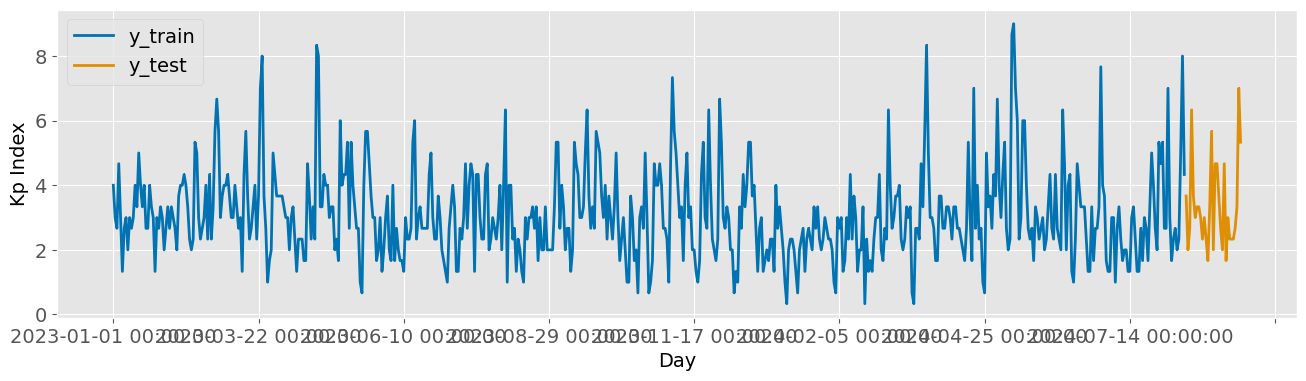

In [50]:
from sktime.forecasting.model_selection import  SlidingWindowSplitter, temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon

# y = daily_max_df[['Datetime', 'Kp_Index']].set_index('Datetime')

# Since data much in the past does not tell much about the future, let's only train data from the past two years to save our computational power. 
daily_max_df_short = daily_max_df[(daily_max_df['Datetime'] >= "2023-01-01")]
y = daily_max_df_short[['Datetime', 'Kp_Index']].set_index('Datetime')

# y_train, y_test = temporal_train_test_split(y, test_size = 365)
y_train, y_test = temporal_train_test_split(y, test_size = 31)
fig, ax = plot_series(y_train, y_test, labels=["y_train", "y_test"],x_label="Day", y_label="Kp Index", markers=[',',','],)

# Verify the split
print(f"Training data length: {len(y_train)}")
print(f"Test data length: {len(y_test)}")

So in this split, the most recent 1 year (365 days) are used as the test set. Based on the result goes, I may need to adjust this value. 

We now need to define a validation set to help us optimize the model. Remember, the golden rule of machine learning is that the algorithm/model should not see the test set until the very last step to report score. 

In [51]:
# Specify forecast horizon. This has the same length minus one as the test set.
fh = ForecastingHorizon(np.arange(1,len(y_test)))
len(fh)

30

In [55]:
# cv = SlidingWindowSplitter(window_length=4015, step_length=365, fh=fh)

cv = SlidingWindowSplitter(window_length=30, step_length=15, fh=fh)

n_splits = cv.get_n_splits(y_train)
print(f"Number of Folds = {n_splits}")

Number of Folds = 36


In [56]:
from warnings import simplefilter
import seaborn as sns
from matplotlib.ticker import MaxNLocator

def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Train",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Validation",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels);
    
def get_windows(y, cv):
    """Generate windows"""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows



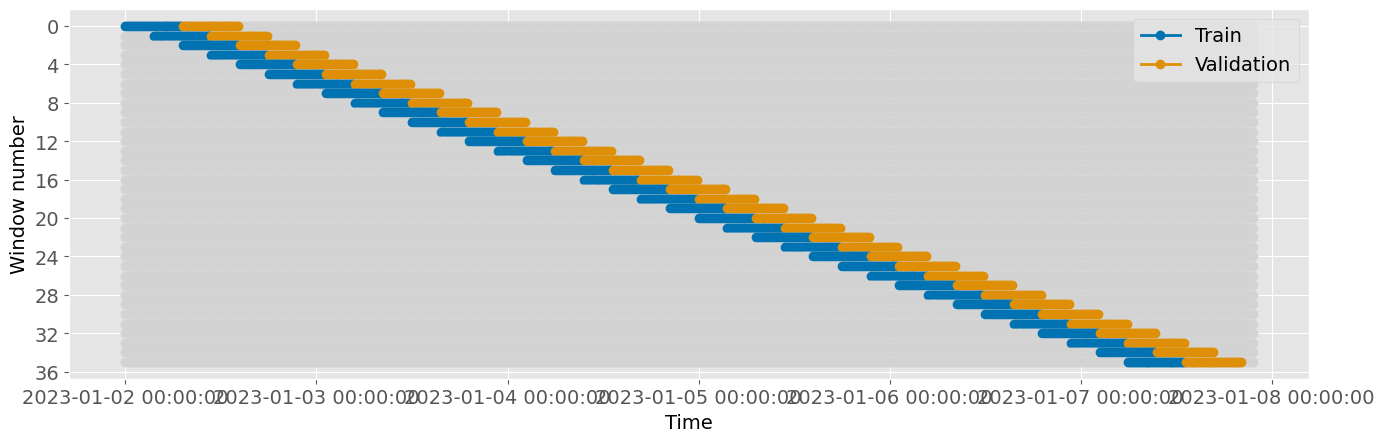

In [57]:
train_windows, test_windows = get_windows(y_train, cv)

plot_windows(y_train, train_windows, test_windows)

To explain how the sliding window works, `window = 4015` indicates that I am using every past 11 years's data to predict the 12th year. The `step_length` indicates that I always skip a year before remaking another prediction. This makes some logical sense as in the EDA section, I showed that in every solar cycle, 11 years, the Kp index repeats. 

## 2.2 Fitting a model

## Baseline models: Naive and Auto-ARIMA
Let's start with a simple baseline model using AutoARIMA.

In [90]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA

import pmdarima as pm

autoarima = pm.auto_arima(y_train, start_q=0,start_d=0,start_p=0,
                            max_q=5, max_d=2, max_p=5)
print(autoarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  591
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -973.720
Date:                Fri, 13 Sep 2024   AIC                           1955.441
Time:                        23:20:22   BIC                           1972.968
Sample:                    01-01-2023   HQIC                          1962.268
                         - 08-13-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5115      0.289      8.678      0.000       1.944       3.079
ar.L1          0.1859      0.090      2.074      0.038       0.010       0.361
ma.L1          0.2925      0.088      3.337      0.0

In [91]:

def create_forecast_index(start, horizon=30, freq="M"):
    return pd.date_range(start + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq, name="Time")


def lag_df(df, lag=1, cols=None):
    """Add lagged columns to dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to add lagged columns to.
    lag : int, optional
        How many lagged values to add. By default = 1.
    cols : list, optional
        Columns to lag. By default all columns in df.

    Returns
    -------
    pd.DataFrame
        DataFrame appended with lagged columns.

    Examples
    --------
    >>> pd.DataFrame({'col': [1, 2]})
    >>> lag_df(df, 3)
       col  col-1  col-2  col-3
    0    1    NaN    NaN    NaN
    1    2    1.0    NaN    NaN
    2    3    2.0    1.0    NaN
    3    4    3.0    2.0    1.0
    """
    if cols is None:
        cols = df.columns
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for col in cols for n in range(1, lag + 1)}
    )

In [93]:
pd.concat((y_train, y_test, autoarima_pred))

,Kp_Index,Label
2023-01-01,4.000000,NaN
2023-01-02,3.000000,NaN
2023-01-03,2.667000,NaN
2023-01-04,4.667000,NaN
2023-01-05,3.000000,NaN
...,...,...
2024-09-08,3.084867,"AUTO_ARIMA(1,0,1) fit"
2024-09-09,3.084867,"AUTO_ARIMA(1,0,1) fit"
2024-09-10,3.084867,"AUTO_ARIMA(1,0,1) fit"
2024-09-11,3.084867,"AUTO_ARIMA(1,0,1) fit"


In [92]:
forecast_index = create_forecast_index(y_train.index[-1], 30, freq="D")

autoarima_pred = pd.DataFrame({"Kp_Index": autoarima.predict(len(forecast_index)),
                      "Label": "AUTO_ARIMA(1,0,1) fit"},
                     index=forecast_index).iloc[1:]
fig = px.line(pd.concat((y_train, y_test, autoarima_pred)), y="Kp_Index", width = 640, color="Label")
fig

In [62]:
forecaster = NaiveForecaster(strategy="last", sp=27) # seasonal period
results = evaluate(forecaster=forecaster, y=y_train, cv=cv, strategy="refit", return_data=True)
results

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,NaN,0.001916,NaN,30,NaT,Kp_Index 2023-01-01 4.000 2023...,Kp_Index 2023-01-31 3.333 2023...,NaN
1,NaN,0.001339,NaN,30,NaT,Kp_Index 2023-01-16 4.000 2023...,Kp_Index 2023-02-15 5.333 2023...,NaN
2,NaN,0.002919,NaN,30,NaT,Kp_Index 2023-01-31 3.333 2023...,Kp_Index 2023-03-02 3.667 2023...,NaN
3,NaN,0.001199,NaN,30,NaT,Kp_Index 2023-02-15 5.333 2023...,Kp_Index 2023-03-17 2.333 2023...,NaN
4,NaN,0.004953,NaN,30,NaT,Kp_Index 2023-03-02 3.667 2023...,Kp_Index 2023-04-01 3.667 2023...,NaN
5,NaN,0.031485,NaN,30,NaT,Kp_Index 2023-03-17 2.333 2023...,Kp_Index 2023-04-16 1.667 2023...,NaN
6,NaN,0.000978,NaN,30,NaT,Kp_Index 2023-04-01 3.667 2023...,Kp_Index 2023-05-01 3.333 2023...,NaN
7,NaN,0.002549,NaN,30,NaT,Kp_Index 2023-04-16 1.667 2023...,Kp_Index 2023-05-16 2.667 2023...,NaN
8,NaN,0.003734,NaN,30,NaT,Kp_Index 2023-05-01 3.333 2023...,Kp_Index 2023-05-31 3.000 2023...,NaN
9,NaN,0.000877,NaN,30,NaT,Kp_Index 2023-05-16 2.667 2023...,Kp_Index 2023-06-15 5.333 2023...,NaN


SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
           dtype='int64', is_relative=True),
                      step_length=15, window_length=30)